In [29]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax import vmap, value_and_grad
import optax
import jaxopt
import enlighten
import os
import scipy

from NNmodels import MLP, MLP_init_params, glorot_normal, MSE

In [14]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
devices = jax.local_devices()
print(devices)

[cuda(id=0)]


In [15]:
tr_config = {"lr_0" : 0.001, 
             "lr_gamma": 0.95,
             "lr_step" : 1000,
             "lr_f" : 1e-5,
             "maxiter_adam" : 1000,
             "maxiter_lbfgs": 1000,
             "deepOnet_width" : 50,
             "trunk_architecture" : [50, 50, 50],
             "trunk_activation": jnp.tanh,
             "trunk_input_dim": 1,
             "trunk_output_dim": 1,
             "trunk_sensor": 100,
             "num_train": 10,
             "num_test": 5}

In [17]:
# Data
# trk_sensor_pts : # trk sensor x trk_net input dim
# trk_targets    : # of data    x # trk sensor
trk_sensor_pts = np.random.uniform(0,1,(tr_config['trunk_sensor'],tr_config['trunk_input_dim']))
for i in range(tr_config['num_train']):
    w = (i+1)/tr_config['num_train']
    if i == 0:
        trk_targets = np.sin(np.pi*w*trk_sensor_pts)
    else:
        trk_targets = np.concatenate([trk_targets, np.sin(np.pi*w*trk_sensor_pts)],axis=1)

In [16]:
# Initialize 'Trunk Network' and 'A'
T_layers   = [tr_config["trunk_input_dim"]] + tr_config["trunk_architecture"] + [tr_config["deepOnet_width"]]
T_act_fn   = tr_config["trunk_activation"]
params_trk = MLP_init_params(T_layers)
NN_trk     = MLP
params_A   = glorot_normal(tr_config['num_train'],tr_config['deepOnet_width']+1)
params     = params_trk, params_A

In [18]:
def DON_step1(params):
    params_trk, params_A = params
    return lambda x: (params_A[:,:-1] @ NN_trk(params_trk, x, T_act_fn)[:,None] + params_A[:,-1][:,None])[:,0]

@jax.jit
def loss_step1(params):
    don_fn = DON_step1(params)
    return MSE(vmap(don_fn, (0))(trk_sensor_pts), trk_targets)

value_grad_fn = value_and_grad(loss_step1)

In [19]:
maxepochs  = tr_config["maxiter_adam"]
lr0        = tr_config["lr_0"]
decay_rate = tr_config["lr_gamma"]
decay_step = tr_config["lr_step"]
lrf        = tr_config["lr_f"]

manager = enlighten.get_manager()
outer_bar_format = u'{desc}{desc_pad}{percentage:3.0f}%|{bar}| ' + \
                 u'{count:{len_total}d}/{total:d} ' + \
                 u'[{elapsed}<{eta}, {rate:.2f}{unit_pad}{unit}/s] ' + \
                 u'{loss}{current_loss:1.4e}'
pbar_outer = manager.counter(total=maxepochs, desc="Main Loop", unit="epochs", color="red", loss="loss=", current_loss=1e+9, bar_format=outer_bar_format)

opt_adam = optax.adam(optax.exponential_decay(lr0, decay_step, decay_rate,end_value=lrf))
opt_state = opt_adam.init(params)

log_loss  = []
log_minloss = []

for epoch in range(maxepochs):
    lvalue, grads = value_grad_fn(params)
    updates, opt_state = opt_adam.update(grads, opt_state)  # arbitrary optim logic!
    params = optax.apply_updates(params, updates)
    pbar_outer.update(current_loss=lvalue)
    if epoch == 0:
        minloss = lvalue
    if lvalue < minloss:
        minloss = lvalue
        params_opt = params
    log_loss.append(lvalue)
    log_minloss.append(minloss)

manager.stop()

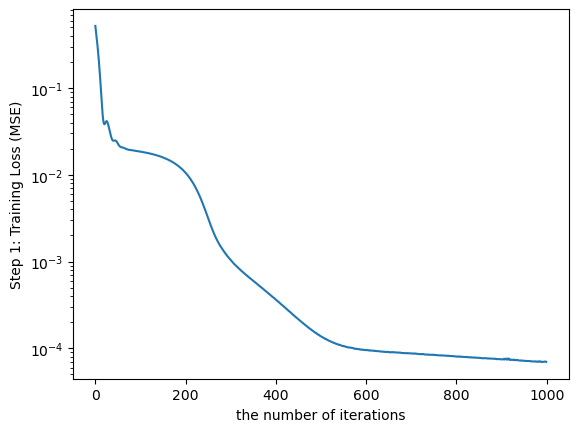

In [20]:
plt.figure()
plt.semilogy(log_loss)
plt.xlabel('the number of iterations')
plt.ylabel('Step 1: Training Loss (MSE)')
plt.show()

In [21]:
opt_lbfgs   = jaxopt.LBFGS(fun=loss_step1, value_and_grad=False, maxiter = tr_config["maxiter_lbfgs"], history_size=10, verbose=True)
res = opt_lbfgs.run(params_opt)
params_opt, state = res

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.00016180751845240593 Stepsize:1.0  Decrease Error:8.173569949576631e-05  Curvature Error:0.00016180751845240593 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 7.458130130544305e-05 Stepsize:0.5  Decrease Error:1.8597982489154674e-05  Curvature Error:7.458130130544305e-05 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): 3.0453626095550135e-05 Stepsize:0.25  Decrease Error:3.994072812929517e-06  Curvature Error:3.0453626095550135e-05 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.039284978061914444  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stop. crit.): 0.00050575245404616 Objective Value:6.968012894503772e-05  Stepsize:0.039284978061914444  Number Linesearch Iterations:4 


In [35]:
params_trk, params_A = params_opt
trk_MAT1 = np.concatenate([vmap(lambda x: NN_trk(params_trk, x, T_act_fn), (0))(trk_sensor_pts),jnp.ones([tr_config["trunk_sensor"],1])], axis=1)
params_A = scipy.linalg.lstsq(trk_MAT1, trk_targets)[0]
q_st, r_st = scipy.linalg.qr(trk_MAT1, mode='economic')
A_target   = r_st @ params_A

In [34]:
# save : params_trk, A_target (must save) | In Step 2, Branch should learn A_target
# save : trk_MAT1, params_A   (optional)

(51, 10)